In [1]:
import os, sys, json
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
%matplotlib inline
from IPython.display import HTML, display
# to display hyperlink as <a> tag in output cells
def display_link(url):
    raw_html = '<a href="%s" target="_blank">%s</a>' % (url, url)
    return display(HTML(raw_html))

import RNAseq

sys.path.append('/Users/zichen/Documents/bitbucket/maayanlab_utils/')
from callDE import *


Loading required package: limma


In [2]:
# The working directory to store all the sequencing data, will be created if not exists
os.environ['WORKDIR'] = '../'

In [6]:
# Read KEGG gmt
def read_gmt(fn):
    d = {}
    with open(fn, 'r') as f:
        for line in f:
            sl = line.strip().split('\t')
            term = sl[0]
            genes = map(lambda x:x.split(',')[0], sl[2:])
            d[term] = genes
    return d

d_gmt = read_gmt('/Users/zichen/Documents/GitLab/gmt_files/KEGG_2016.gmt')
print d_gmt['p53 signaling pathway_Homo sapiens_hsa04115']
# print d_gmt.keys()

['APAF1', 'SHISA5', 'TSC2', 'CDK6', 'TP53I3', 'RRM2B', 'CDK4', 'FAS', 'CCNG2', 'CDK2', 'CCNG1', 'BAX', 'ATM', 'CDK1', 'CYCS', 'STEAP3', 'ATR', 'TP53', 'EI24', 'CD82', 'SERPINE1', 'GORAB', 'RCHY1', 'BBC3', 'CASP8', 'CCND3', 'CASP9', 'CCND2', 'CHEK1', 'CCND1', 'CHEK2', 'PERP', 'BAI1', 'CASP3', 'RPRM', 'GTSE1', 'PIDD1', 'SIAH1', 'SERPINB5', 'RRM2', 'CDKN2A', 'GADD45B', 'GADD45A', 'IGFBP3', 'GADD45G', 'IGF1', 'TNFRSF10B', 'DDB2', 'TP73', 'PPM1D', 'RFWD2', 'CCNE2', 'CCNE1', 'MDM4', 'MDM2', 'CDKN1A', 'PTEN', 'THBS1', 'CCNB3', 'SESN1', 'TP53AIP1', 'CCNB2', 'CCNB1', 'ZMAT3', 'SESN2', 'SESN3', 'PMAIP1', 'SFN', 'BID']


## 1. Load the expression data

In [7]:
## Load the expression matrix
expr_df = pd.read_csv(os.path.join(os.environ['WORKDIR'], 'zebra_expression_map_3.tsv'), sep='\t')
print expr_df.shape
expr_df.head()

(32013, 24)


,cul3a_crispr_1,wasf2_crispr_2,wasf2_crispr_3,wasf2_crispr_4,wasf2_control_1,wasf2_control_2,wasf2_control_3,wasf2_control_4,racgap1_crispr_1,racgap1_crispr_2,...,racgap1_control_2,racgap1_crispr_3,racgap1_control_4,cul3a_crispr_3,cul3a_crispr_4,cul3a_control_1,cul3a_control_2,cul3a_control_3,cul3a_control_4,wasf2_crispr_1
RERG,71,54,231,77,87,41,184,66,137,105,...,103,101,74,39,33,100,46,41,39,72
SI:CH73-252I11.1,145,85,186,95,110,104,123,57,307,235,...,85,168,61,120,107,70,43,55,45,131
SYN3,7,4,21,3,6,3,8,5,9,4,...,19,12,10,3,12,7,8,6,6,22
PTPRO,1582,1306,1213,1342,1434,2553,891,1252,2080,2233,...,2621,2252,2919,1766,1893,1511,1473,1818,1165,1930
EPS8,444,233,501,234,260,285,458,144,532,486,...,305,530,253,363,387,318,253,278,261,310


In [8]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 0, :]
print expr_df.shape

## Filter out lowly expressed genes
mask_low_vals = (expr_df > 10).sum(axis=1) > 2
expr_df = expr_df.loc[mask_low_vals, :]

print expr_df.shape

(28572, 24)
(23113, 24)


In [9]:
def clean_gene_symbol(gene):
    if gene.endswith('(1 OF MANY)'):
        gene = gene.split(' (')[0]
    return gene

expr_df.index = expr_df.index.map(clean_gene_symbol)

In [10]:
# Make a df to store meta data of samples
meta_df = pd.DataFrame(index=expr_df.columns, 
                       columns=['genotype', 'gene', 'perturbation'])

for sample_id in expr_df.columns:
    genotype = '_'.join(sample_id.split('_')[0:2])
    gene = sample_id.split('_')[0]
    perturbation = sample_id.split('_')[1]
    meta_df.ix[sample_id] = [genotype, gene, perturbation]
    

## 2. Call DEGs using voom-limma

In [11]:
q_value_cutoff = 0.05
lfc_cutoff = 1

sample_classes = {}
limma_results = {}
d_comparisons_limma = {}

# Compare KO over WT for each gene
for gene in meta_df['gene'].unique():
    is_gene = (meta_df['gene'] == gene)
    is_ko_for_gene = (meta_df['perturbation'] == 'crispr') & is_gene
    sample_classes['%s_KO-vs-WT' % gene] = is_gene.values.astype(int) + is_ko_for_gene.values.astype(int)


for comp, sample_class in sample_classes.items():
    res = runVoomLimma(expr_df.values, expr_df.index.tolist(), sample_class) 
    res_df = pd.DataFrame(res, index=expr_df.index)
    # drop duplicated genes, only keep the one with smallest p-value
    res_df = res_df.sort_values('qvalues').reset_index().groupby('index').first()

    limma_results[comp] = res_df
    qvals = res_df['qvalues']
    lfcs = res_df['logFC']

    up_genes = res_df.index[(qvals<q_value_cutoff) & (lfcs > lfc_cutoff)].unique().tolist()
    dn_genes = res_df.index[(qvals<q_value_cutoff) & (lfcs < lfc_cutoff)].unique().tolist()

    # split up and down
    d_comparisons_limma[comp+'-up'] = {gene: res_df.ix[gene].values for gene in up_genes}
    d_comparisons_limma[comp+'-dn'] = {gene: res_df.ix[gene].values for gene in dn_genes}
    
    print comp, ': #up genes:', len(up_genes), '#down genes:', len(dn_genes)
    

cul3a_KO-vs-WT : #up genes: 31 #down genes: 36
racgap1_KO-vs-WT : #up genes: 853 #down genes: 7410
wasf2_KO-vs-WT : #up genes: 0 #down genes: 0


### Check if CRISRed genes are down-regualted

In [12]:
limma_results['cul3a_KO-vs-WT'].ix['CUL3A']

logFC     -1.106670e+00
pvalues    2.528493e-08
qvalues    2.225059e-04
Name: CUL3A, dtype: float64

In [13]:
limma_results['cul3a_KO-vs-WT'].ix['CUL3B']

logFC     -0.001480
pvalues    0.985578
qvalues    0.998008
Name: CUL3B, dtype: float64

In [14]:
limma_results['racgap1_KO-vs-WT'].ix['RACGAP1']

logFC     -0.594482
pvalues    0.000506
qvalues    0.003330
Name: RACGAP1, dtype: float64

In [15]:
limma_results['racgap1_KO-vs-WT'].ix[['STAT3', 'ISL1', 'JAK1']]

,logFC,pvalues,qvalues
index,,,
STAT3,1.210784,3.710117e-07,0.000027
ISL1,-1.288710,2.164529e-07,0.000019
JAK1,0.931309,1.259833e-06,0.000058


In [16]:
limma_results['wasf2_KO-vs-WT'].ix['WASF2']

logFC     -0.418251
pvalues    0.051527
qvalues    0.999844
Name: WASF2, dtype: float64

### Volcano plots

In [46]:
def volcano_plot(res_df):
    fig, ax = plt.subplots()
    ax.scatter(res_df['logFC'], -np.log10(res_df['qvalues']),
              s=5, alpha=0.4)
    ax.set_xlabel('log2 fold change', fontsize=18)
    ax.set_ylabel('-log10(q-value)', fontsize=18)    
    return fig, ax

def volcano_plot_highlight(res_df, genes_to_highlight, qvalue=0.1):
    fig, ax = plt.subplots()
    
    genes_to_highlight = list(set(res_df.index) & set(genes_to_highlight))
    other_genes = list(set(res_df.index)- set(genes_to_highlight))
    

    ax.scatter(res_df.ix[other_genes]['logFC'], -np.log10(res_df.ix[other_genes]['qvalues']),
              s=5, alpha=0.2,
              edgecolor='none')
    ax.scatter(res_df.ix[genes_to_highlight]['logFC'], -np.log10(res_df.ix[genes_to_highlight]['qvalues']),
              s=10, alpha=0.6, c='r',
              edgecolor='none')
    
    for gene in genes_to_highlight:
        q = res_df.ix[gene]['qvalues']
        if q < qvalue:
            ax.annotate(gene, (res_df.ix[gene]['logFC'], -np.log10(res_df.ix[gene]['qvalues'])),
                       color='r')
    
    ax.set_xlabel('log2 fold change', fontsize=18)
    ax.set_ylabel('-log10(q-value)', fontsize=18)    
    return fig, ax


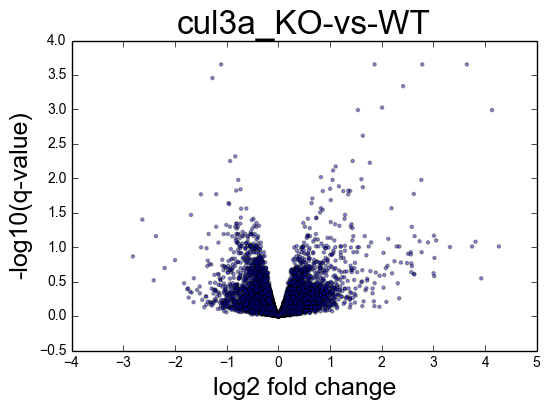

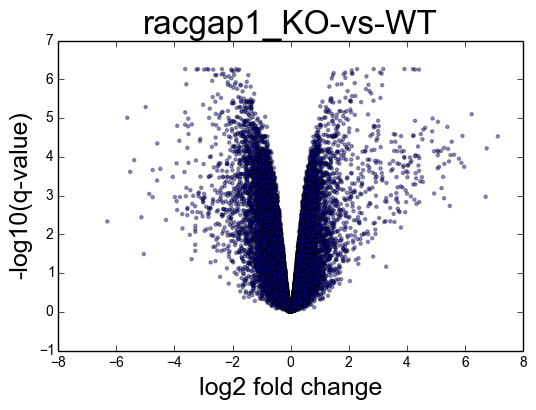

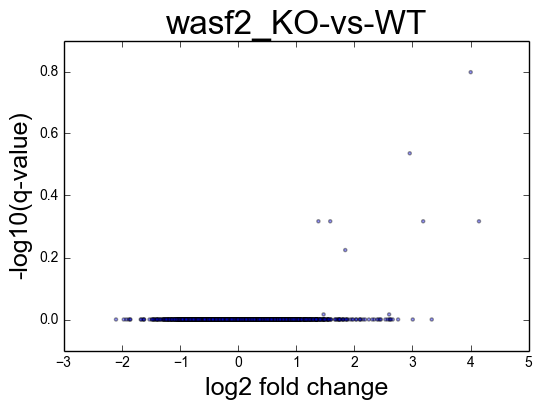

In [27]:
for comp in limma_results:
    fig, ax = volcano_plot(limma_results[comp])
    ax.set_title(comp, fontsize=24)
#     fig.savefig('%s.pdf' % comp)

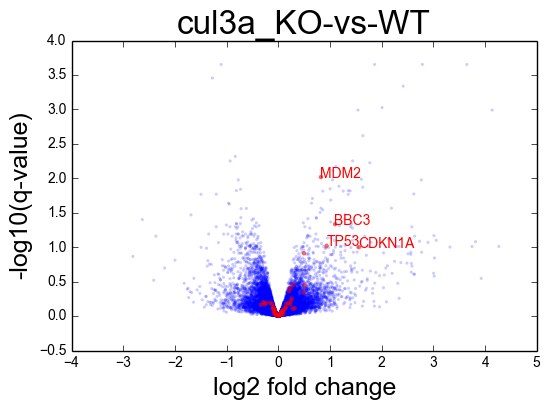

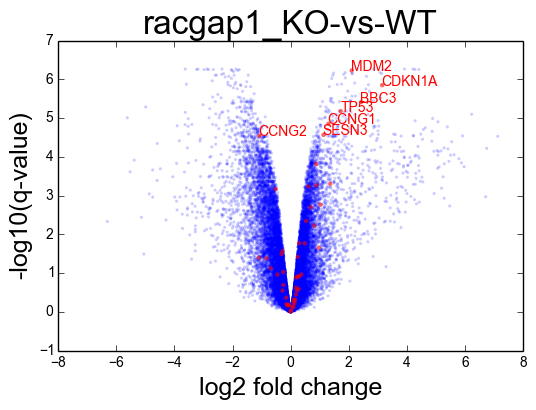

In [47]:
# for comp in limma_results:
comp = 'cul3a_KO-vs-WT'
fig, ax = volcano_plot_highlight(limma_results[comp], 
                                 d_gmt['p53 signaling pathway_Homo sapiens_hsa04115'],
                                qvalue=0.1)
ax.set_title(comp, fontsize=24)
fig.savefig('%s.pdf' % comp)

comp = 'racgap1_KO-vs-WT'
fig, ax = volcano_plot_highlight(limma_results[comp], d_gmt['p53 signaling pathway_Homo sapiens_hsa04115'],
                                qvalue=0.0001)
ax.set_title(comp, fontsize=24)
fig.savefig('%s.pdf' % comp)

In [15]:
limma_results['wasf2_KO-vs-WT'].sort_values('qvalues').head(10)

,logFC,pvalues,qvalues
index,,,
C3A.3,4.003334,0.000007,0.159292
SI:CH211-278N20.8,2.954680,0.000025,0.290960
SI:DKEY-8K3.2,1.586740,0.000125,0.482120
C3A.2,3.185817,0.000115,0.482120
MMP9,1.383558,0.000121,0.482120
CPN1,4.145767,0.000119,0.482120
CABZ01064972.2,1.845169,0.000181,0.597059
BMB,1.472356,0.000375,0.962968
SI:DKEY-40H20.1,2.600041,0.000373,0.962968


### Call DEGs after adjusting cutoffs

In [38]:
d_comparisons_limma = {}

cutoffs = {
    'cul3a_KO-vs-WT': {'qval': 0.1, 'lfc': 0},
    'racgap1_KO-vs-WT': {'qval': 0.0001, 'lfc': 1},
    'wasf2_KO-vs-WT': {'qval': 0.5, 'lfc': 0},
}

for comp, res_df in limma_results.items():
    
    qvals = res_df['qvalues']
    lfcs = res_df['logFC']
    # split up and down
    up_genes = res_df.index[(qvals<cutoffs[comp]['qval']) & (lfcs > cutoffs[comp]['lfc'])].unique().tolist()
    dn_genes = res_df.index[(qvals<cutoffs[comp]['qval']) & (lfcs < -cutoffs[comp]['lfc'])].unique().tolist()
    
    if len(up_genes) > 0:
        d_comparisons_limma[comp+'-up'] = {gene: res_df.ix[gene].values for gene in up_genes}
    if len(dn_genes) > 0:
        d_comparisons_limma[comp+'-dn'] = {gene: res_df.ix[gene].values for gene in dn_genes}
    
    print comp, ': #up genes:', len(up_genes), '#down genes:', len(dn_genes)
    

cul3a_KO-vs-WT : #up genes: 92 #down genes: 87
racgap1_KO-vs-WT : #up genes: 210 #down genes: 358
wasf2_KO-vs-WT : #up genes: 6 #down genes: 0


## 3. Enrichment analysis

In [39]:
## Generate Enrichr links for up/down genes in an Excel file with the gene sets.
enrichr_result_file = os.path.join(os.environ['WORKDIR'], 'Enrichr_links_Limma.xls')
RNAseq.dict2xls_with_vals(d_comparisons_limma, ['gene', 'log2_fold_change', 'p-value', 'q-value'], 
                          enrichr_result_file)

In [40]:
## Check the Enrichr results
enrichr_results = pd.read_excel(enrichr_result_file, sheetname=None)
pd.set_option('display.max_colwidth', -1)
enrichr_results['Enrichr_links']['Link'] = enrichr_results['Enrichr_links']['Link']\
    .apply(lambda x: '<a href="%s" target="_blank">%s</a>' %(x, x))

HTML(enrichr_results['Enrichr_links'].to_html(escape=False))

,Gene list,Size,Link
0,cul3a_KO-vs-WT-dn,87,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b0lk
1,cul3a_KO-vs-WT-up,92,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b0ll
2,racgap1_KO-vs-WT-dn,358,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b0lm
3,racgap1_KO-vs-WT-up,210,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b0ln
4,wasf2_KO-vs-WT-up,6,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b0lo
